In [8]:
#IMPORTS
import string
from collections import Counter
import datetime as dt
from numpy import array
import numpy as np
import pickle
from pickle import load, dump
# from keras.applications.inception_v3 import InceptionV3
from keras.applications import ResNet152V2
from keras.models import Model
from keras.preprocessing import image
# from keras.applications.inception_v3 import preprocess_input
from keras.applications.resnet_v2 import preprocess_input
from keras import Input
from keras.layers import Dropout, Dense, Embedding, LSTM
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#RUN THIS CELL ONLY ONCE#

#EXTRACTING TEXT DATA AND PREPROCESSING
#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
file = open(filepath, 'r')
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A DICTIONARY FOR TIME EFFICIENCY PURPOSES
tokens_dic = {}
for line in lines:
    tokens = line.split()
    image_ = tokens[0]
    caption = ' '.join(tokens[1:])
    image_title = image_.split('.')[0]
    if(image_title not in tokens_dic.keys()):
        tokens_dic[image_title] = [caption]
    else:
        tokens_dic[image_title].append(caption)


#STEP: PREPROCESSING
table = str.maketrans('', '', string.punctuation)
for captions in tokens_dic.values():
    for i in range(len(captions)):
        caption = captions[i]
        words = caption.split()
        words = [word.lower() for word in words]
        words = [word.translate(table) for word in words]
        words = [word for word in words if len(word)>1]
        words = [word for word in words if word.isalpha()]
        captions[i] = ' '.join(words)


#LOADING TRAINING SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
train = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    train.append(image_title)
#NOTE: SIZE OF TRAIN LIST IS 6000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
train_dataset = {}
max_caption_length = 0
for image_title, captions in tokens_dic.items():
    if(image_title in train and (image_title not in train_dataset.keys())):
        train_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            train_dataset[image_title].append(refined_caption)
            max_caption_length = max(max_caption_length, len(refined_caption.split()))
#NOTE: SIZE OF TRAIN DATASET IS 6000


#LOADING CROSS VALIDATION(OR DEVELOPMENT) SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
dev = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    dev.append(image_title)
#NOTE: SIZE OF TEST LIST IS 1000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
dev_dataset = {}
for image_title, captions in tokens_dic.items():
    if(image_title in dev and (image_title not in dev_dataset.keys())):
        dev_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            dev_dataset[image_title].append(refined_caption)
#NOTE: SIZE OF DEV DATASET IS 1000


#LOADING TESTING SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
test = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    test.append(image_title)
#NOTE: SIZE OF TEST LIST IS 1000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
test_dataset = {}
for image_title, captions in tokens_dic.items():
    if(image_title in test and (image_title not in test_dataset.keys())):
        test_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            test_dataset[image_title].append(refined_caption)
#NOTE: SIZE OF TEST DATASET IS 1000


#CONSTRUCTING VOCABULARY FROM CAPTIONS
vocabulary = set()
for captions in tokens_dic.values():
    for caption in captions:
        for word in caption.split():
            vocabulary.add(word)
#NOTE: SIZE OF VOCABULARY BY NOT LETTING 1 LENGTH WORDS BE IN CAPTION IS 8763

#CONSTRUCTING MOST PROBABLE VOCABULARY FROM ALL TRAIN WORDS
word_count_threshold = 10
all_train_words = []
for captions in train_dataset.values():
    for caption in captions:
        words = caption.split()
        for word in words:
            all_train_words.append(word)

counter = Counter(all_train_words)
commons = counter.most_common()
most_probable_vocabulary = set()
for ele in commons:
    if(ele[1]>=word_count_threshold):
        most_probable_vocabulary.add(ele[0])
vocabulary_size = len(most_probable_vocabulary)
#NOTE: SIZE OF MOST PROBABLE VOCABULARY BY NOT LETTING 1 LENGTH WORDS BE IN CAPTION IS 1651

In [3]:
model = ResNet152V2(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

242753536/242745792 [==============================] - 1334s 5us/step


In [10]:
#TO GET INPUT VECTOR X FROM IMAGES WE USE TRANSFER LEARNING THROUGH ResNet152V2 MODEL TRAINED ON 1000 DIFFERENT CLASSES OF IMAGES

encoded_train_images = {}
start = dt.datetime.now()
i = 0
for image_title in train_dataset.keys():
    image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+image_title+".jpg"
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    encoded_train_images[image_title] = feature_vec
    present = dt.datetime.now()
    if((i/500).is_integer()):
        print("{}th ITERATION".format(i))
        print("TIME SO FAR: {}s".format((present-start).total_seconds()))
    i+=1
end = dt.datetime.now()
print("TIME TAKEN TO ENCODE TRAIN IMAGES INTO 2048 LENGTH FEATURE VECTOR: {}s".format((end-start).total_seconds()))


encoded_dev_images = {}
start = dt.datetime.now()
i = 0
for image_title in dev_dataset.keys():
    image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+image_title+".jpg"
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    encoded_dev_images[image_title] = feature_vec
    present = dt.datetime.now()
    if((i/500).is_integer()):
        print("{}th ITERATION".format(i))
        print("TIME SO FAR: {}s".format((present-start).total_seconds()))
    i+=1
end = dt.datetime.now()
print("TIME TAKEN TO ENCODE DEV IMAGES INTO 2048 LENGTH FEATURE VECTOR: {}s".format((end-start).total_seconds()))


encoded_test_images = {}
start = dt.datetime.now()
i = 0
for image_title in test_dataset.keys():
    image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+image_title+".jpg"
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    encoded_test_images[image_title] = feature_vec
    present = dt.datetime.now()
    if((i/500).is_integer()):
        print("{}th ITERATION".format(i))
        print("TIME SO FAR: {}s".format((present-start).total_seconds()))
    i+=1
end = dt.datetime.now()
print("TIME TAKEN TO ENCODE TEST IMAGES INTO 2048 LENGTH FEATURE VECTOR: {}s".format((end-start).total_seconds()))

0th ITERATION
TIME SO FAR: 7.016009s
500th ITERATION
TIME SO FAR: 180.50307s
1000th ITERATION
TIME SO FAR: 354.190523s
1500th ITERATION
TIME SO FAR: 525.015956s
2000th ITERATION
TIME SO FAR: 702.852102s
2500th ITERATION
TIME SO FAR: 887.489708s
3000th ITERATION
TIME SO FAR: 1074.264945s
3500th ITERATION
TIME SO FAR: 1263.569526s
4000th ITERATION
TIME SO FAR: 1447.075513s
4500th ITERATION
TIME SO FAR: 1629.296038s
5000th ITERATION
TIME SO FAR: 1810.16231s
5500th ITERATION
TIME SO FAR: 1993.542733s
TIME TAKEN TO ENCODE TRAIN IMAGES INTO 2048 LENGTH FEATURE VECTOR: 2171.605411s
0th ITERATION
TIME SO FAR: 0.383489s
500th ITERATION
TIME SO FAR: 178.777509s
TIME TAKEN TO ENCODE DEV IMAGES INTO 2048 LENGTH FEATURE VECTOR: 357.577392s
0th ITERATION
TIME SO FAR: 0.39414s
500th ITERATION
TIME SO FAR: 180.366978s
TIME TAKEN TO ENCODE TEST IMAGES INTO 2048 LENGTH FEATURE VECTOR: 362.859028s


In [11]:
#WRITING ENCODED TRAIN IMAGES, ENCODED DEV IMAGES AND ENCODED TEST IMAGES TO PKL FILES
with open("encoded_train_images2.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_train_images, encoded_pickle)
    
with open("encoded_test_images2.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_test_images, encoded_pickle)
    
with open("encoded_dev_images2.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_dev_images, encoded_pickle)

In [12]:
#RUN THIS CELL ONLY ONCE#

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocabulary_size+1)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0
                

#USEFUL DICTIONARIES
index_to_word = {}
word_to_index = {}
index = 1
for word in most_probable_vocabulary:
    index_to_word[index] = word
    word_to_index[word] = index
    index+=1
    
    
#WORD EMBEDDINGS, MAPPING EVERY WORD OF OUR MOST PROBABALE VOCABULARY TO 200 DIMENSION VECTOR, FOR THAT WE WILL BE USING GLOVE
embeddings = {}
file = open("../../../Downloads/glove/glove.6B.200d.txt", "r")
content = file.read()
file.close()
lines = content.split('\n')
for line in lines:
    word_and_vector = line.split()
    word = word_and_vector[0]
    vector = word_and_vector[1:]
    vector = np.asarray(vector, dtype='float32')
    embeddings[word] = vector
    
    
#MAPPING MOST PROBABLE VOCABULARY TO VECTOR BY CREATING A DENSE MATRIX WITH ROW AS WORD AND COLUMNS ARE 200 DIMENSIONS OF VECTOR
embedding_dim = 200
embeddings_matrix = np.zeros((vocabulary_size+1, embedding_dim))
for word, index in word_to_index.items():
    vector = embeddings.get(word)
    if(vector is not None):
        embeddings_matrix[index]=vector
#NOTE: DIMENSION OF EMBEDDINGS MATRIX IS (MOST PROBABLE VOCABULARY X 200), HERE (1951 X 200)
#NOTE: 1ST ROW OF EMBEDDINGS MATRIX IS ALL ZEROS

# model
<img src="files/images/model1_arch.png?1">
<img src="files/images/model_summary.png?1">
<img src="files/images/model_performance.png?1">

# model2
<img src="files/images/model2_arch.png?1">
<img src="files/images/model2_summary.png?1">
<img src="files/images/model2_performance.png?1">

# model3
<img src="files/images/model3_arch.png?1">
<img src="files/images/model3_summary.png?1">
<img src="files/images/model3_performance.png?1">

In [13]:
#HYBRID ARCHITECTURE RESULTANT FROM MODEL2 AND MODEL3 ARCHITECTURE
input1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(input1)
fe2 = Dense(512, activation='relu')(fe1)
fe3 = Dense(256, activation='relu')(fe2)

input2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocabulary_size+1, embedding_dim, mask_zero=True)(input2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)
se4 = Dense(256)(se3)

decoder1 = add([fe3, se4])
decoder2 = Dense(512, activation='relu')(decoder1)
decoder3 = Dense(256, activation='relu')(decoder2)

output = Dense(vocabulary_size+1, activation='softmax')(decoder3)
model4 = Model(inputs=[input1, input2], outputs=output, name="model4")

model4.summary()

Model: "model4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
_____________________________________________________________________________________________

In [14]:
#SETTING ADDITIONAL PROPERTIES FOR EMBEDDING LAYER I.E. NO TRAINING ON EMBEDDINGS LAYER
model4.layers[2].set_weights([embeddings_matrix])
model4.layers[2].trainable = False

#COMPILING THE MODEL
model4.compile(loss='categorical_crossentropy', optimizer='adam')

In [15]:
#USING THE SAME PARAMETERS AS MODEL2 FOR TRAINING SESSION 1
#HYPERPARAMETERS OF TRAINING SESSION 1
#NOTE: DEFAULT LEARNING RATE OF KERAS MODEL IS 0.001
epochs = 20
batch_size = 3
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [16]:
#TRAINING SESSION 1
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    model4.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
model4.save('./model4_weights/model_' + str(0) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 1745s 873ms/step - loss: 4.1438
Epoch 1/1
2000/2000 [==============================] - 1756s 878ms/step - loss: 3.4720
Epoch 1/1
2000/2000 [==============================] - 2078s 1s/step - loss: 3.2472
Epoch 1/1
2000/2000 [==============================] - 1969s 984ms/step - loss: 3.1051
Epoch 1/1
2000/2000 [==============================] - 1878s 939ms/step - loss: 3.0038
Epoch 1/1
2000/2000 [==============================] - 1862s 931ms/step - loss: 2.9249
Epoch 1/1
2000/2000 [==============================] - 1865s 932ms/step - loss: 2.8609
Epoch 1/1
2000/2000 [==============================] - 1994s 997ms/step - loss: 2.8088
Epoch 1/1
2000/2000 [==============================] - 1975s 988ms/step - loss: 2.7661
Epoch 1/1
2000/2000 [==============================] - 1971s 986ms/step - loss: 2.7261
Epoch 1/1
2000/2000 [==============================] - 1964s 982ms/step - loss: 2.6952
Epoch 1/1
2000/2000 [=========================

In [17]:
#TWEAKED THE PARAMETERS(LEARNING RATE DECAY)
#HYPERPARAMETERS OF TRAINING SESSION 2
#NOTE: LEARNING RATE IS CHANGED TO 0.0005
K.set_value(model4.optimizer.lr, 0.0005)
epochs = 5
batch_size = 4
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [18]:
#TRAINING SESSION 2
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    model4.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
model4.save('./model4_weights/model_' + str(1) + '.h5')

Epoch 1/1
1500/1500 [==============================] - 1578s 1s/step - loss: 2.4072
Epoch 1/1
1500/1500 [==============================] - 1538s 1s/step - loss: 2.3465
Epoch 1/1
1500/1500 [==============================] - 1553s 1s/step - loss: 2.3178
Epoch 1/1
1500/1500 [==============================] - 1594s 1s/step - loss: 2.2877
Epoch 1/1
1500/1500 [==============================] - 1590s 1s/step - loss: 2.2679


In [19]:
#TWEAKED THE PARAMETERS(LEARNING RATE DECAY)
#HYPERPARAMETERS OF TRAINING SESSION 3
#NOTE: LEARNING RATE IS CHANGED TO 0.0003
K.set_value(model4.optimizer.lr, 0.0003)
epochs = 5
batch_size = 6
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [20]:
#TRAINING SESSION 3
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    model4.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
model4.save('./model4_weights/model_' + str(2) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 1482s 1s/step - loss: 2.2286
Epoch 1/1
1000/1000 [==============================] - 1465s 1s/step - loss: 2.1991
Epoch 1/1
1000/1000 [==============================] - 1467s 1s/step - loss: 2.1811
Epoch 1/1
1000/1000 [==============================] - 1469s 1s/step - loss: 2.1664
Epoch 1/1
1000/1000 [==============================] - 1473s 1s/step - loss: 2.1514


In [167]:
#LOADING TRAINED WEIGHTS TO MODEL
model4.load_weights('./model4_weights/model_2.h5')

In [168]:
def predict4(feature_vec):
    partial_caption = "startseq"
    for i in range(max_caption_length):
        seq = [word_to_index[word] for word in partial_caption.split() if word in word_to_index]
        seq = pad_sequences([seq], maxlen=max_caption_length)
        yhat = model4.predict([feature_vec,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        partial_caption += ' ' + word
        if word == 'endseq':
            break
    final_caption = partial_caption.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

model4
3420284416_a90af1fb7a


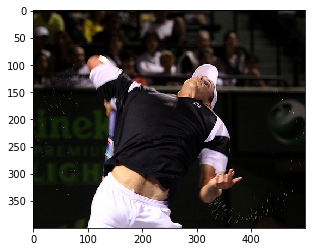

prediction: two men are playing wrestling game one of which is about to hit the ball
Ground Truth: baseball player is on the field in fronmt of an audience
Ground Truth: man in black top and white cap is stretching backwards in sports stadium
Ground Truth: man wearing white hat swings his arm back to throw
Ground Truth: tennis player about to serve
Ground Truth: tennis player is serving the ball


In [169]:
#OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("model4")
print(key)
feature_vec = encoded_dev_images[key].reshape((1, 2048))
image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+key+".jpg"
image_ = plt.imread(image_path)
plt.imshow(image_)
plt.show()
print("prediction: {}".format(predict4(feature_vec)))
for caption in dev_dataset[key]:
    caption = ' '.join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

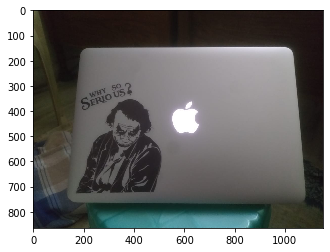

prediction: two children are sitting in the trunk of car


In [170]:
#OBSERVATION OF PERFORMANCE ON RANDOM IMAGES INPUT FROM LOCAL MACHINE
def image_to_feature_vec(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    return feature_vec.reshape((1, 2048))

image_path = "../../../Downloads/laptop_test.jpeg"
feature_vec = image_to_feature_vec(image_path)
image_ = plt.imread(image_path)
plt.imshow(image_)
plt.show()
print("prediction: {}".format(predict4(feature_vec)))

In [171]:
#PERFORMANCE ON TRAIN DATASET, DEV DATASET
batch_size = 3
steps = len(train_dataset)//batch_size
train_generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
train_performance = model4.evaluate(train_generator, steps=steps, verbose=0)

batch_size = 4
steps = len(dev_dataset)//batch_size
dev_generator = data_generator(dev_dataset, encoded_dev_images, word_to_index, max_caption_length, batch_size)
dev_performance = model4.evaluate(dev_generator, steps=steps, verbose=0)

print("LOSS ON TRAIN DATASET: {}".format(train_performance))
print("LOSS ON DEV DATASET: {}".format(dev_performance))

LOSS ON TRAIN DATASET: 1.908781886100769
LOSS ON DEV DATASET: 4.075953483581543
